In [23]:
import uuid
import glob
import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
AUTOTUNE = tf.data.experimental.AUTOTUNE

from net import unet_mobile, linknet_mobile

from IPython.display import clear_output
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
OUTPUT_CHANNELS = 2

TRAIN_DIR = "data/train_image"
TRAIN_MASK_DIR = "data/train_mask"
VAL_DIR = "data/val_image"
VAL_MASK_DIR = "data/val_mask"

TRAIN_PATH = "data/train_image/class_0"
TRAIN_MASK_PATH = "data/train_mask/class_0"
VAL_PATH = "data/val_image/class_0"
VAL_MASK_PATH = "data/val_mask/class_0"

EPOCH = 100
BATCH_SIZE = 64

RES_DIR = "result"
MODEL_NAME = "unet_mobile_" + str(IMG_WIDTH) + "_" + str(EPOCH) +"epoch"
RES_DIR = os.path.join(RES_DIR, MODEL_NAME)
if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)

In [25]:
# for image_name in glob.glob(os.path.join(TRAIN_PATH, "class_0", "*")):
#     old_name = image_name.split("/")[-1].replace(".jpg", "")
#     new_name = uuid.uuid4().hex
# #     print(image_name, image_name.replace(old_name, new_name))
# #     print(image_name.replace("train_image", "train_mask"), image_name.replace(old_name, new_name).replace("train_image", "train_mask"))
#     os.rename(image_name, image_name.replace(old_name, new_name))
#     os.rename(image_name.replace("train_image", "train_mask").replace("jpg", "png"), 
#               image_name.replace(old_name, new_name).replace("train_image", "train_mask").replace("jpg", "png"))

In [26]:
# for image_name in glob.glob(os.path.join(VAL_PATH, "class_0", "*")):
#     old_name = image_name.split("/")[-1].replace(".jpg", "")
#     new_name = uuid.uuid4().hex
# #     print(image_name, image_name.replace(old_name, new_name))
# #     print(image_name.replace("train_image", "train_mask"), image_name.replace(old_name, new_name).replace("train_image", "train_mask"))
#     os.rename(image_name, image_name.replace(old_name, new_name))
#     os.rename(image_name.replace("val_image", "val_mask").replace("jpg", "png"), 
#               image_name.replace(old_name, new_name).replace("val_image", "val_mask").replace("jpg", "png"))

## Data Generator

In [11]:
TRAINSET_SIZE = len(glob.glob(os.path.join(TRAIN_PATH, "*.jpg")))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
VALSET_SIZE = len(glob.glob(os.path.join(VAL_PATH, "*.jpg")))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")
TRAIN_STEP = TRAINSET_SIZE // BATCH_SIZE
VAL_STEP = VALSET_SIZE // BATCH_SIZE

The Training Dataset contains 1896 images.
The Validation Dataset contains 475 images.


In [12]:
def resize_and_rescale(image, mask):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    mask = tf.cast(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_WIDTH, IMG_HEIGHT])
    return image, mask

def augment(image, mask):
    image, mask = resize_and_rescale(image, mask)
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, IMG_WIDTH + 6, IMG_HEIGHT + 6) 
    mask = tf.image.resize_with_crop_or_pad(mask, IMG_WIDTH + 6, IMG_HEIGHT + 6) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[IMG_WIDTH, IMG_HEIGHT, 3])
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0, 1)
    mask = tf.image.random_crop(mask, size=[IMG_WIDTH, IMG_HEIGHT, 1])
    mask = tf.image.random_brightness(mask, max_delta=0.5) # Random brightness
    mask = tf.clip_by_value(mask, 0, 1)
    return image, mask

In [13]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # For one Image path:
    # .../trainset/images/training/ADE_train_00000001.jpg
    # Its corresponding annotation path is:
    # .../trainset/annotations/training/ADE_train_00000001.png
    mask_path = tf.strings.regex_replace(img_path, "image", "mask")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}

In [14]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_WIDTH, IMG_HEIGHT))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_WIDTH, IMG_HEIGHT))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.adjust_saturation(input_image, 3)
    if tf.random.uniform(()) > 0.5:        
        input_image = tf.image.adjust_brightness(input_image, 0.4)
#     if tf.random.uniform(()) > 0.5:
#         input_image = tf.image.central_crop(input_image, central_fraction=0.5)
#         input_mask = tf.image.central_crop(input_mask, central_fraction=0.5)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.rot90(input_image)
        input_mask = tf.image.rot90(input_mask)
        
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_WIDTH, IMG_HEIGHT))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_WIDTH, IMG_HEIGHT))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [15]:
SEED = 1

In [16]:
train_dataset = tf.data.Dataset.list_files(os.path.join(TRAIN_PATH, "*.jpg"), seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(os.path.join(VAL_PATH, "*.jpg"), seed=SEED)
val_dataset =val_dataset.map(parse_image)

In [17]:
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [18]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

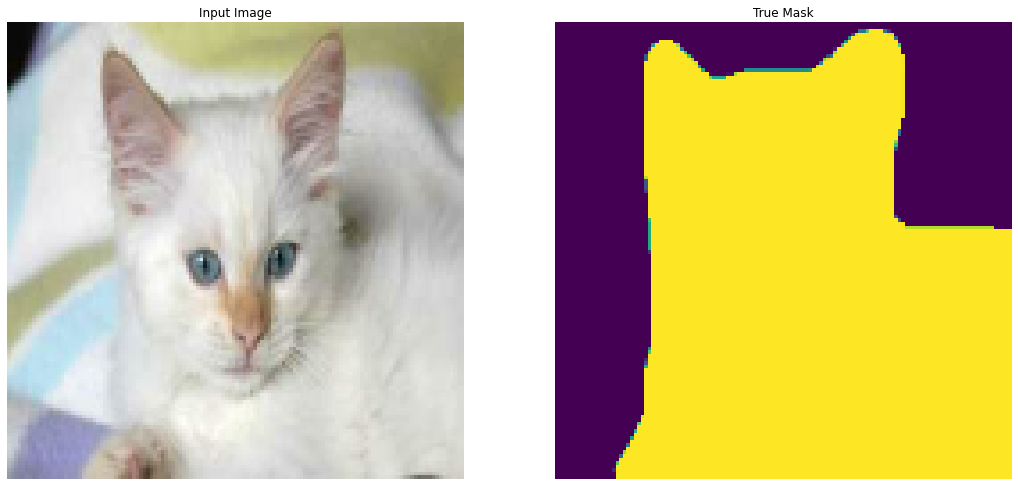

In [19]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

## Create Model

In [20]:
model = unet_mobile.build_model(OUTPUT_CHANNELS)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[1][3]                

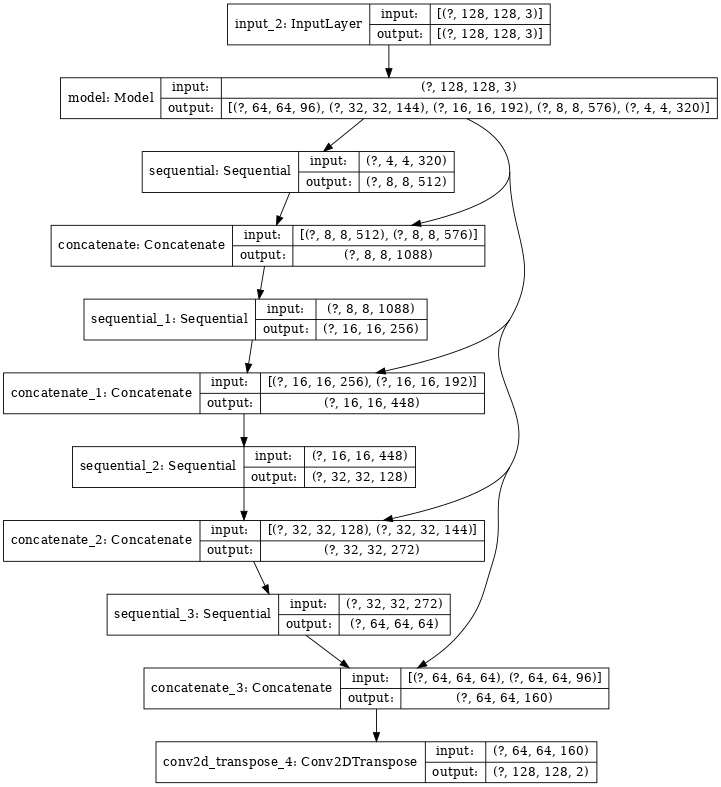

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64, to_file=os.path.join(RES_DIR, 'model_structure.png'),)

---
## Visualize <a class="anchor" id="vis"></a>

In [29]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)[0]])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

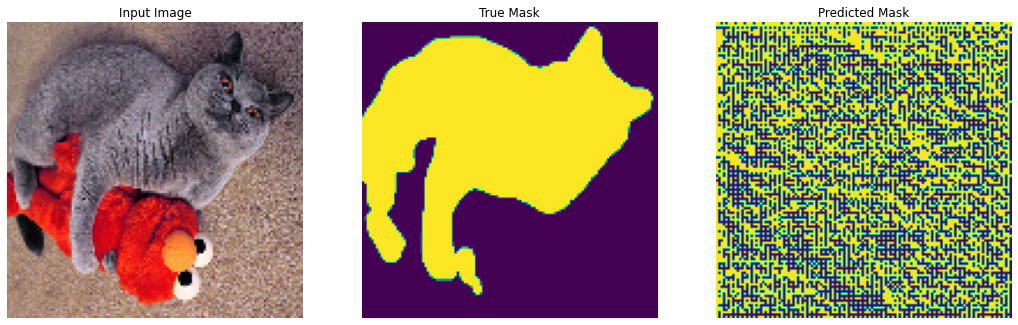

In [39]:
for image, mask in dataset['val'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

## Train

In [40]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [42]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(os.path.join(RES_DIR, "best_checkpoint.h5"), verbose=1, save_best_only=True)

In [43]:
callbacks = [
#     earlystopper, 
    checkpointer, 
    DisplayCallback()
]

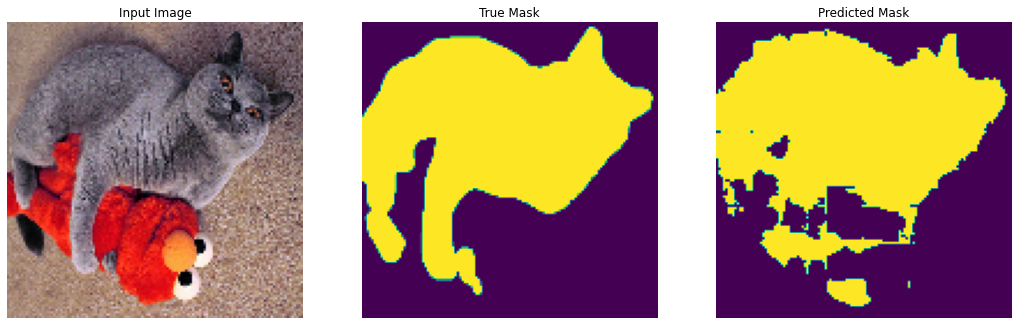


Sample Prediction after epoch 100

29/29 [==============================] - 6s 205ms/step - loss: 0.0618 - accuracy: 0.9694 - val_loss: 0.2146 - val_accuracy: 0.9372


In [44]:
model_history = model.fit(
    dataset['train'], 
    steps_per_epoch=TRAIN_STEP,
    
    validation_steps=VAL_STEP,
    validation_data=dataset['val'], 
    
    epochs=EPOCH,
    callbacks=callbacks
)

In [45]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(20, 12))
    # Acc
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'o-', label = "Train Acc")
    plt.plot(history.history['val_accuracy'], 'o-', label = "Val Acc")
    plt.title("Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    # Loss
    plt.subplot(222)
    plt.plot(history.history['loss'],'o-', label = "Train Loss")
    plt.plot(history.history['val_loss'], 'o-', label = "Val Loss")
    plt.title("Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()

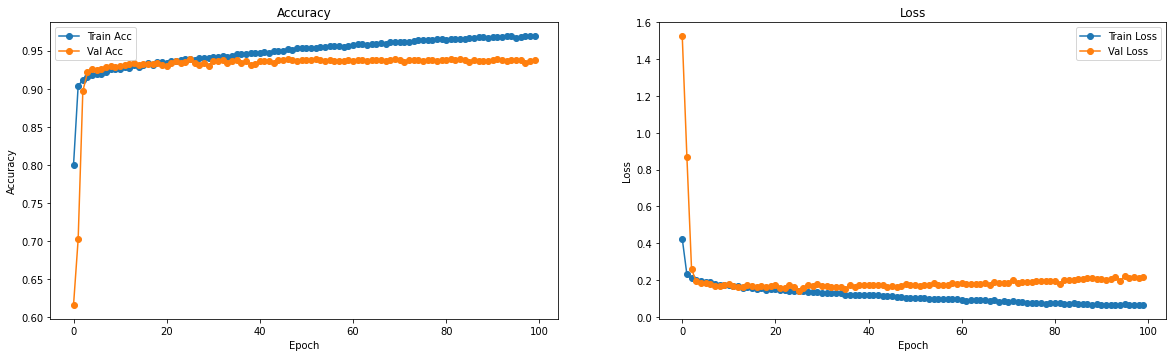

In [46]:
plot_accuracy_loss(model_history)
plt.show()

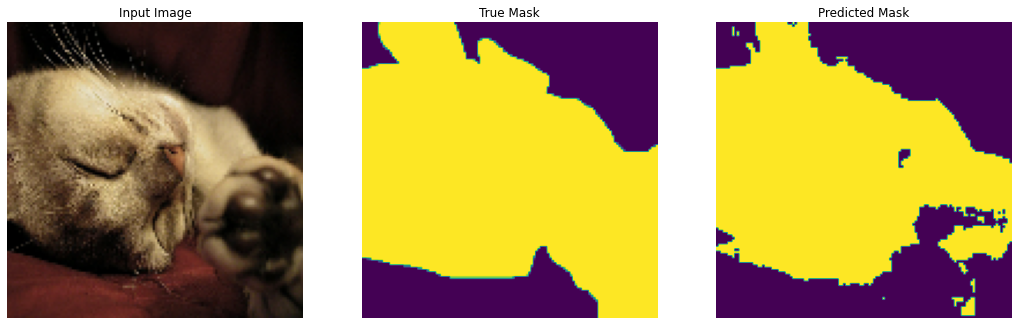

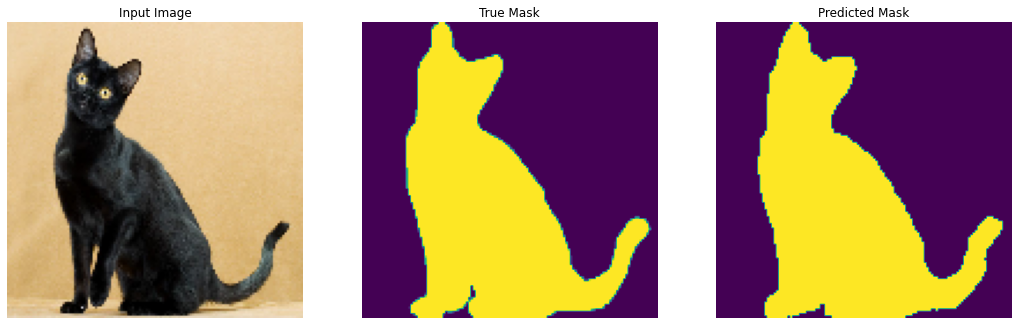

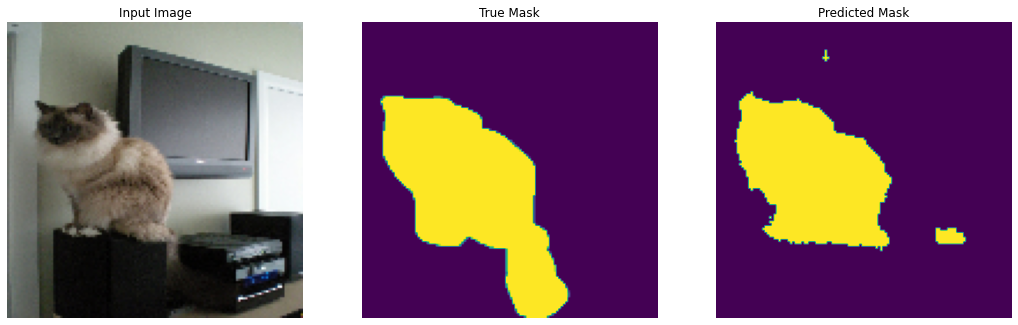

In [47]:
show_predictions(dataset['val'], 3)

In [48]:
plot_accuracy_loss(model_history)
plt.savefig(os.path.join(RES_DIR, "acc_loss.png"))
plt.close()

In [49]:
model.save(os.path.join(RES_DIR, "final_model.h5"))